### hyper opt로 RF 튜닝

* Hyperopt is different in that it encourages you to describe your search space in more detail.

The way to use hyperopt is to describe

* the objective function to minimize
* the space over which to search
* the database in which to store all the point evaluations of the search
* the search algorithm to use

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from hyperopt.pyll.stochastic import sample
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.ensemble import RandomForestClassifier # rf분류기

In [2]:
def f1(X_val, y_val, model,mapping):
    """
    Model evaluation function for multiclass classification problem
    1) F-1 score, Precision, Recall
    2) ROC curve, PR curve는 추후에 생각
    """
 
    #### predict the value
    y_pred = model.predict(X_val)

    #print('-'*50)
    #print('2. F1-score')
    
    # inverse pre/ rec
    pre = precision_score(y_true = y_val, y_pred = y_pred, average=None)
    rec = recall_score(y_true = y_val, y_pred = y_pred, average=None)

    # f1 measure
    f1_score = 8/(sum(1/pre) + sum(1/rec))
    
    # view - precision recall
    table = pd.DataFrame([])

    for i,k in enumerate(mapping.keys()):
        table[k] = [pre[i],rec[i]]
    table.index = ['precision','recall']
    # print(table)
    
    # view - f1
    #print('F1_score %.3f'%f1_score)
    #print('='*50)
    return f1_score

In [3]:
#### load data set
## train
X_train1 = pd.read_csv('temp_data/X_train_stat.csv')
X_train2 = pd.read_csv('temp_data/X_train_easy_time.csv').drop('new_id',axis=1)
X_train2.columns = [x +'_basic_time' for x in X_train2.columns]
X_train3 = pd.read_csv('temp_data/X_train_게임활동_time.csv').drop('new_id',axis=1)
X_train3.columns = [x +'_time_series' for x in X_train3.columns]
X_train6 = pd.read_csv('temp_data/X_train_ratio.csv').drop('new_id',axis=1)
X_train6.fillna(0.0)
X_train9 = pd.read_csv('temp_data/X_train_act_comb_1.csv').drop('new_id',axis=1)
X_train10 = pd.read_csv('temp_data/train_playpattern_mean_encoding.csv').drop('new_id',axis=1)
X_train11 = pd.read_csv('temp_data/train_interaction_sum_30.csv').drop('new_id',axis=1)

## test
X_test1 = pd.read_csv('temp_data/X_test_stat.csv')
X_test2 = pd.read_csv('temp_data/X_test_easy_time.csv').drop('new_id',axis=1)
X_test2.columns = X_train2.columns
X_test3 = pd.read_csv('temp_data/X_test_게임활동_time.csv').drop('new_id',axis=1)
X_test3.columns = X_train3.columns
X_test6 = pd.read_csv('temp_data/X_test_ratio.csv').drop('new_id',axis=1)
X_test6.fillna(0.0)
X_test9 = pd.read_csv('temp_data/X_test_act_comb_1.csv').drop('new_id',axis=1)
X_test10 = pd.read_csv('temp_data/test_playpattern_mean_encoding.csv').drop('new_id',axis=1)
X_test11 = pd.read_csv('temp_data/test_interaction_sum_30.csv').drop('new_id',axis=1)

## guild and trade and party
X_train4 = pd.read_csv('temp_data/temp_guild_train.csv').drop('new_id',axis=1)
X_train5 = pd.read_csv('temp_data/temp_trade_train.csv').drop('new_id',axis=1)
X_test4 = pd.read_csv('temp_data/temp_guild_test.csv').drop('new_id',axis=1)
X_test5 = pd.read_csv('temp_data/temp_trade_test.csv').drop('new_id',axis=1)
X_train7 = pd.read_csv('temp_data/X_train_party.csv').drop('new_id',axis=1)
X_test7 = pd.read_csv('temp_data/X_test_party.csv').drop('new_id',axis=1)
X_train8 = pd.read_csv('temp_data/training_trade.csv').drop('new_id',axis=1)
X_test8 = pd.read_csv('temp_data/test_trade.csv').drop('new_id',axis=1)

In [4]:
X_train = pd.concat((X_train1,X_train2,X_train3,X_train4,X_train5, X_train6,X_train7,X_train8,X_train9,X_train10,X_train11),axis=1).drop('new_id',axis=1)
X_test = pd.concat((X_test1,X_test2,X_test3,X_test4,X_test5,X_test6,X_test7,X_test8,X_test9,X_test10,X_test11),axis=1).drop('new_id',axis=1)

In [5]:
#### load class
train_label = pd.read_csv('temp_data/train_label_lite.csv')
hasher = pd.read_csv('temp_data/test_id.csv')
label_map = {'retained':0,'2month':1,'month':2,'week':3}
inv_map = {label_map[k]:k for k in label_map.keys()}
y_train = pd.Series([label_map[l] for l in train_label.label])

In [6]:
### nan 제거
X_train = X_train.fillna(0)

---

In [12]:
X_train.shape

(100000, 495)

In [13]:
#### RF 모델
model = RandomForestClassifier(criterion='gini',max_features= 243, min_samples_leaf= 4,n_estimators=300,random_state= 7, n_jobs=-1)
X_train_rf = X_train.fillna(0)

In [14]:
#### cross validation
kfold = StratifiedKFold(n_splits = 5 ,random_state = 7).split(X_train_rf, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    model.fit(X_train_rf.iloc[train,:], y_train[train])
    score = f1(X_train_rf.iloc[test,:], y_train[test], model,label_map)
    scores.append(score)
    print('Fold: %s, Class dist.: %s, F1: %.3f' % (k+1,np.bincount(y_train[train]), score))
    
print('\nCV F1: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Class dist.: [20000 20000 20000 20000], F1: 0.719
Fold: 2, Class dist.: [20000 20000 20000 20000], F1: 0.723
Fold: 3, Class dist.: [20000 20000 20000 20000], F1: 0.716
Fold: 4, Class dist.: [20000 20000 20000 20000], F1: 0.715
Fold: 5, Class dist.: [20000 20000 20000 20000], F1: 0.713

CV F1: 0.717 +/- 0.004


In [15]:
#### RF 모델
model = RandomForestClassifier(criterion='gini',max_features= 235, min_samples_leaf= 3,n_estimators=300,random_state= 7, n_jobs=-1)
X_train_rf = X_train.fillna(0)

In [16]:
#### cross validation
kfold = StratifiedKFold(n_splits = 5 ,random_state = 7).split(X_train_rf, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    model.fit(X_train_rf.iloc[train,:], y_train[train])
    score = f1(X_train_rf.iloc[test,:], y_train[test], model,label_map)
    scores.append(score)
    print('Fold: %s, Class dist.: %s, F1: %.3f' % (k+1,np.bincount(y_train[train]), score))
    
print('\nCV F1: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Class dist.: [20000 20000 20000 20000], F1: 0.720
Fold: 2, Class dist.: [20000 20000 20000 20000], F1: 0.723
Fold: 3, Class dist.: [20000 20000 20000 20000], F1: 0.715
Fold: 4, Class dist.: [20000 20000 20000 20000], F1: 0.715
Fold: 5, Class dist.: [20000 20000 20000 20000], F1: 0.714

CV F1: 0.717 +/- 0.003


---

__n_estimators 튜닝__

In [35]:
from sklearn.model_selection import train_test_split
X_tr, X_v, y_tr, y_v = train_test_split(X_train, y_train)

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
rf.fit(X_tr, y_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [37]:
predictions = []
for tree in rf.estimators_:
    predictions.append(tree.predict_proba(X_v)[None, :])

In [38]:
predictions = np.vstack(predictions)

In [39]:
cum_mean = np.cumsum(predictions, axis=0)/np.arange(1, predictions.shape[0] + 1)[:, None, None]

In [40]:
scores = []
for pred in cum_mean:
    scores.append(accuracy_score(y_v, np.argmax(pred, axis=1)))

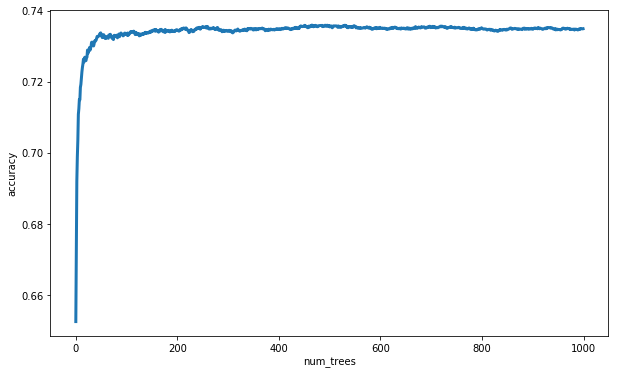

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(scores, linewidth=3)
plt.xlabel('num_trees')
plt.ylabel('accuracy');

__hyperopt__

In [7]:
obj_call_count = 0
cur_best_score = 0
cur_best_std = 0

In [8]:
param_space = {
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1,15)),
    'max_depth': hp.choice('max_depth', range(7,60)),
    'max_features': hp.choice('max_features', range(int(np.sqrt(X_train.shape[1])),400)),
    'n_estimators': 300,
    'criterion': hp.choice('criterion',['gini','entropy']),
    'random_state':7,
    'n_jobs' : -1
    }

In [9]:
def rf_classifier(params): # hyperopt의 objective function은 params를 input으로 받는다.
    
    global obj_call_count, cur_best_score, cur_best_std, X_train, y_train # 우리가 input할 데이터는 global변수화!
    
    obj_call_count += 1
    print('\nRandom_forest objective call #{} cur_best_score={:7.5f} cur_best_std={:7.5f}'.format(obj_call_count,cur_best_score,cur_best_std) )
    
    #### sampling parameters from the hyperparameter params
    rf_params = sample(params)
    model = RandomForestClassifier(**rf_params)
    
    #### 5 fold cross validation for rf
    kfold = StratifiedKFold(n_splits = 5 ,random_state = 7,shuffle=True).split(X_train, y_train)
    scores = []
    predict_set = []
    for k, (train, test) in enumerate(kfold):
        model.fit(X_train.iloc[train,:], y_train[train])
        score = f1(X_train.iloc[test,:], y_train[test], model,label_map)
        scores.append(score)
        
        ### predict values...
        y_pred = model.predict(X_train.iloc[test,:])
        predict_set += [(x,inv_map[y_pred[i]]) for i,x in enumerate(test)]
        
    f1_mean = np.mean(scores)
    f1_std = np.std(scores)
    
    print(rf_params)
    print('5-fold of randomforest F1: %.3f +/- %.3f' % (f1_mean, f1_std))
    
    if f1_mean > cur_best_score:
        cur_best_score = f1_mean
        cur_best_std = f1_std
        
    #### minimize metric
    loss = 1 - f1_mean
    loss_var = 1 - np.var(scores)
    
    return {'loss': loss , 'loss_variance': loss_var ,'status':STATUS_OK ,'attachments':{'pred_cv':predict_set}}

In [10]:
trials = Trials()

In [11]:
best = fmin(rf_classifier, param_space, algo=tpe.suggest, max_evals=100,trials=trials)
print ('best:')
print (best)


Random_forest objective call #1 cur_best_score=0.00000 cur_best_std=0.00000
{'criterion': 'entropy', 'max_depth': 8, 'max_features': 68, 'min_samples_leaf': 7, 'n_estimators': 300, 'n_jobs': -1, 'random_state': 7}
5-fold of randomforest F1: 0.669 +/- 0.004

Random_forest objective call #2 cur_best_score=0.66910 cur_best_std=0.00432
{'criterion': 'gini', 'max_depth': 39, 'max_features': 191, 'min_samples_leaf': 11, 'n_estimators': 300, 'n_jobs': -1, 'random_state': 7}
5-fold of randomforest F1: 0.713 +/- 0.005

Random_forest objective call #3 cur_best_score=0.71261 cur_best_std=0.00523
{'criterion': 'gini', 'max_depth': 52, 'max_features': 126, 'min_samples_leaf': 14, 'n_estimators': 300, 'n_jobs': -1, 'random_state': 7}
5-fold of randomforest F1: 0.710 +/- 0.005

Random_forest objective call #4 cur_best_score=0.71261 cur_best_std=0.00523
{'criterion': 'gini', 'max_depth': 59, 'max_features': 131, 'min_samples_leaf': 3, 'n_estimators': 300, 'n_jobs': -1, 'random_state': 7}
5-fold of ra

{'criterion': 'entropy', 'max_depth': 36, 'max_features': 226, 'min_samples_leaf': 3, 'n_estimators': 300, 'n_jobs': -1, 'random_state': 7}
5-fold of randomforest F1: 0.718 +/- 0.004

Random_forest objective call #34 cur_best_score=0.71973 cur_best_std=0.00439
{'criterion': 'entropy', 'max_depth': 29, 'max_features': 110, 'min_samples_leaf': 8, 'n_estimators': 300, 'n_jobs': -1, 'random_state': 7}
5-fold of randomforest F1: 0.717 +/- 0.006

Random_forest objective call #35 cur_best_score=0.71973 cur_best_std=0.00439
{'criterion': 'entropy', 'max_depth': 30, 'max_features': 250, 'min_samples_leaf': 11, 'n_estimators': 300, 'n_jobs': -1, 'random_state': 7}
5-fold of randomforest F1: 0.715 +/- 0.005

Random_forest objective call #36 cur_best_score=0.71973 cur_best_std=0.00439
{'criterion': 'entropy', 'max_depth': 16, 'max_features': 237, 'min_samples_leaf': 4, 'n_estimators': 300, 'n_jobs': -1, 'random_state': 7}
5-fold of randomforest F1: 0.715 +/- 0.004

Random_forest objective call #37

{'criterion': 'gini', 'max_depth': 45, 'max_features': 316, 'min_samples_leaf': 14, 'n_estimators': 300, 'n_jobs': -1, 'random_state': 7}
5-fold of randomforest F1: 0.711 +/- 0.005

Random_forest objective call #66 cur_best_score=0.72134 cur_best_std=0.00463
{'criterion': 'gini', 'max_depth': 19, 'max_features': 117, 'min_samples_leaf': 1, 'n_estimators': 300, 'n_jobs': -1, 'random_state': 7}
5-fold of randomforest F1: 0.721 +/- 0.004

Random_forest objective call #67 cur_best_score=0.72134 cur_best_std=0.00463
{'criterion': 'gini', 'max_depth': 19, 'max_features': 84, 'min_samples_leaf': 1, 'n_estimators': 300, 'n_jobs': -1, 'random_state': 7}
5-fold of randomforest F1: 0.720 +/- 0.004

Random_forest objective call #68 cur_best_score=0.72134 cur_best_std=0.00463
{'criterion': 'gini', 'max_depth': 32, 'max_features': 71, 'min_samples_leaf': 1, 'n_estimators': 300, 'n_jobs': -1, 'random_state': 7}
5-fold of randomforest F1: 0.716 +/- 0.004

Random_forest objective call #69 cur_best_scor

KeyboardInterrupt: 